In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import cv2
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter


In [2]:
class MaxPool(nn.Module):
    def __init__(self, pool_size):
        super(MaxPool, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        return self.pool(x)


class Noise(nn.Module):
    def __init__(self, R_scale):
        super(Noise, self).__init__()
        self.mean = 0
        self.stdev = 1  # as defined in the paper

    def forward(self, d_coarse):
        noise = torch.rand_like(d_coarse)*self.stdev + self.mean
        d_noised = d_coarse + noise
        return d_noised


class IntervalThreshold(nn.Module):
    def __init__(self, m, n):
        super(IntervalThreshold, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_pool):
        threshold = (torch.max(d_pool) - torch.min(d_pool))/min(self.m, self.n)
        return threshold


class ReconGraph(nn.Module):
    def __init__(self, m, n):
        super(ReconGraph, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_noised, threshold):
        neighbours = set()
        labels = {}

        count = 0

        for i in range(self.m):
            for j in range(self.n):

                labels[(j, i)] = count  # Labeling each pixel in (x, y) form
                count += 1
                for dy in range(-1, 2):
                    for dx in range(-1, 2):
                        if dx != 0 and dy != 0 and i+dy >= 0 and i+dy < self.m and j+dx >= 0 and j+dx < self.n:
                            if abs(d_noised[0][0][i+dy][j+dx] - d_noised[0][0][i][j]) <= threshold:
                                # (x, y) format
                                neighbours.add(((j, i), (j+dx, i+dy)))
        adjacency_matrix = torch.zeros((self.m*self.n, self.m*self.n), dtype=bool)
        print(adjacency_matrix.shape)

        for val in neighbours:

            N1, N2 = val #in (x, y) form
            N1_x, N1_y = N1
            N2_x, N2_y = N2

            l1 = labels[(N1_x, N1_y)]
            l2 = labels[(N2_x, N2_y)]

            # Symmetric connections
            adjacency_matrix[l1, l2] = 1
            adjacency_matrix[l2, l1] = 1

        return adjacency_matrix


class GraphDropout(nn.Module):
    def __init__(self, p=0.5) -> None:
        super(GraphDropout, self).__init__()
        self.p = p

    def forward(self, adjacency_matrix):
        if self.train:
            mask = torch.empty_like(adjacency_matrix).bernoulli_(1 - self.p)
            output = adjacency_matrix * mask

        else:
            output = adjacency_matrix

        return output


class ExtractGraph(nn.Module):

    def __init__(self, d_coarse, R_scale, m, n) -> None:
        super(ExtractGraph, self).__init__()
        self.d_coarse = d_coarse
        self.R_scale = R_scale

        self.maxpool = MaxPool(pool_size=2)
        self.noise = Noise(R_scale=0.4)  # From paper results
        self.interval_threshold = IntervalThreshold(m, n)
        self.recon_graph = ReconGraph(m, n)
        self.dropout = GraphDropout(p=0.5)

    def forward(self):
        d_pool = self.maxpool.forward(self.d_coarse)
        print("pooled shape ", d_pool.shape)
        d_noise = self.noise.forward(d_pool)
        threshold = self.interval_threshold.forward(d_pool)
        adjacency_matrix = self.recon_graph.forward(d_noise, threshold)
        adjacency_matrix = self.dropout.forward(adjacency_matrix)

        return adjacency_matrix


In [5]:
class Encoder(nn.Module):

    def __init__(self) -> None:
        super(Encoder, self).__init__()
        encoder = models.resnet.resnet50(
            weights=models.ResNet50_Weights.DEFAULT)
        encoder = nn.Sequential(*list(encoder.children()))[:4]
        self.resnet_encoder = encoder

    def forward(self, x):
        self.resnet_encoder.eval()
        return self.resnet_encoder(x)


In [42]:
class GNNModel(nn.Module):

    def __init__(self, n_features) -> None:
        super(GNNModel, self).__init__()
        self.gcn1 = pyg_nn.GCNConv(n_features, 128)
        self.gcn2 = pyg_nn.GCNConv(128, 256)
        self.gcn3 = pyg_nn.GCNConv(256, 32)
        self.gcn4 = pyg_nn.GCNConv(32, 1)
    


    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        x = F.relu(self.gcn3(x, edge_index))
        x = F.relu(self.gcn4(x, edge_index))

        return x

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from PIL import Image  
import torchvision.transforms as transforms

encoder = Encoder()
image = Image.open("../test_images/inputs/skyscraper_city.jpeg")

print("Original shape ", image.size)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_image = transform(image).unsqueeze(0)
node_features = encoder.forward(input_image)

print("Shape after encoder ", node_features.shape)


Original shape  (1920, 1280)
Shape after encoder  torch.Size([1, 64, 320, 480])


In [13]:
model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

img = cv2.imread("../test_images/inputs/skyscraper_city.jpeg")
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img).to(device)


#Interpolate to the downsampled shape
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = F.interpolate(
        prediction.unsqueeze(1),
        size=node_features.shape[2:4],
        mode="bicubic",
        align_corners=False
    ).squeeze()

depth_map = prediction.cpu()
print("shape through midas ", depth_map.shape)


Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/adityadandwate/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


(1280, 1920, 3)


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


shape through midas  torch.Size([320, 480])


In [26]:
# At this point, the node features are in node_features while the depth map is in depth_map
reshaped_depth_map = torch.reshape(depth_map, (1, 1, depth_map.shape[0], depth_map.shape[1]))
print(reshaped_depth_map.shape)
graph_extract = ExtractGraph(reshaped_depth_map, 0.4, int(reshaped_depth_map.shape[2]/2), int(reshaped_depth_map.shape[3]/2))
adjacency_matrix = graph_extract.forward()
adjacency_matrix.shape
# print((i, j) for i in range(adjacency_matrix.shape[0]) for j in range(adjacency_matrix.shape[0]) if adjacency_matrix[i, j] == 1

torch.Size([1, 1, 320, 480])
pooled shape  torch.Size([1, 1, 160, 240])
torch.Size([38400, 38400])


torch.Size([38400, 38400])

In [29]:
# Pool node features to match the number of nodes in adjacency matrix
pooler = MaxPool(pool_size=2)
node_features = pooler.forward(node_features)
node_features.shape

torch.Size([1, 64, 160, 240])

In [30]:
node_labels = {}
count = 0
for i in range(node_features.shape[2]):
            for j in range(node_features.shape[3]):

                node_labels[(j, i)] = count  # Labeling each pixel in (x, y) form
                count += 1
# node_features = node_features.T()
# node_features.shape

In [33]:
node_features = torch.reshape(node_features, (64, -1))
node_features.shape
node_features = node_features.t()
node_features.shape


torch.Size([38400, 64])

In [37]:
from tqdm import tqdm
def adjacency_matrix_to_edge_index(adjacency_matrix):
    # Get the dimensions of the adjacency matrix
    num_nodes = adjacency_matrix.shape[0]

    # Create an empty list to store the edge indices
    edge_index = []

    # Iterate over the adjacency matrix and find the non-zero entries
    for i in tqdm(range(num_nodes)):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] != 0:
                edge_index.append([i, j])

    # Convert the list of edge indices to a PyTorch tensor
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return edge_index


In [39]:
adj_coo = adjacency_matrix.to_sparse().coalesce()
edge_index = adj_coo.indices()
edge_index.shape

torch.Size([2, 60270])

In [45]:
gnn = GNNModel(node_features.shape[1])
output = gnn.forward(node_features, edge_index)
output.shape

torch.Size([38400, 1])

In [47]:
output = output.t()
output = torch.reshape(output, (1, 160, 240))
output.shape



torch.Size([1, 160, 240])

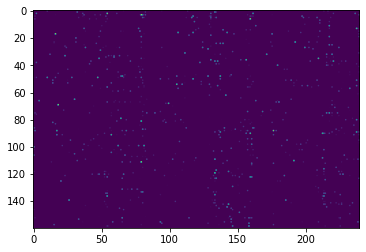

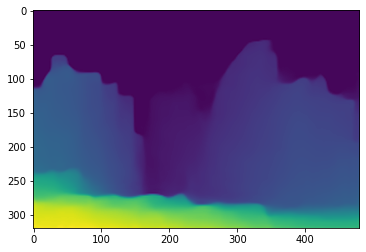

In [52]:
import matplotlib.pyplot as plt

image_array = output.permute(1, 2, 0).detach().numpy()
plt.imshow(image_array)
plt.show()

depth1 = depth_map.detach().numpy()
plt.imshow(depth1)
plt.show()

In [54]:
test = torch.tensor([1, 2, 3, 4, 5, 6])
test = test.reshape(6, 1)   # (6, 1)

test = test.t()
test.shape      # (1, 6)

torch.Size([1, 6])

In [56]:
test = test.reshape(1, 2, 3)
test.shape  #(1, 2, 3)
test

tensor([[[1, 2, 3],
         [4, 5, 6]]])

In [57]:
test = test.reshape(1, 6)
test

tensor([[1, 2, 3, 4, 5, 6]])